# Color Scheme Generator

The purpose of this notebook is to generate large sets of attractive and accessible color schemes based on Mathew Strom's work in [*How to pick the least wrong colors*](https://matthewstrom.com/writing/how-to-pick-the-least-wrong-colors).

## Section 0: Environment Setup

This section prepares the environment by importing the necessary Python modules for this notebook. It also includes code to define a list of target "good" colors to use as a starting point for the color generation process. This list does not have to be used; in the event that it is not, the notebook will choose random colors as a starting point.

In [1]:
# const chroma = require("chroma-js");
import math
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# const targetColors = [
#     "#9966FF",
#     "#0055BC",
#     "#00A1C2",
#     "#ED6804",
#     "#B3063D"
# ];
targetColors = [
    "#9966FF",
    "#0055BC",
    "#00A1C2",
    "#ED6804",
    "#B3063D"
]

## Section 1: Utility Functions

This notebook relies on several helper utility functions. These are defined in this section.

In [3]:
# // random from array
# const randomFromArray = (array) => {
#     return array[Math.floor(Math.random() * array.length)];
# };

def randomFromArray(array):
    """
    Selects a random element from a given array (list).

    This function takes an array (list in Python terminology) and returns
    a random element from it. The function does not modify the original array.

    Parameters:
    array (list): A list from which a random element is to be selected. 
                  The list should not be empty.

    Returns:
    element: A randomly selected element from the input list. The type of
             the element depends on the content of the list.

    Raises:
    ValueError: If the input array is empty.

    Example:
        >>> my_list = [1, 2, 3, 4, 5]
        >>> print(randomFromArray(my_list))
        3  # This is an example output, actual output will be random.
    """

    if not array:
        raise ValueError("Input array is empty.")

    return random.choice(array)

In [4]:
def randomNFromArray(array, n):
    """
    Selects n random elements from a given array (list).

    This function takes an array (list in Python terminology) and returns
    n random elements from it. The function does not modify the original array.

    Parameters:
    array (list): A list from which random elements are to be selected. 
                  The list should not be empty.
    n (int): The number of random elements to select from the input list.
             Should be a non-negative integer not greater than the length of the array.

    Returns:
    list: A list containing n randomly selected elements from the input list.
          The elements in the output list maintain their original order.

    Raises:
    ValueError: If the input array is empty or if n is not a non-negative integer
                or if n is greater than the length of the array.

    Example:
        >>> my_list = [1, 2, 3, 4, 5]
        >>> print(random_items_from_array(my_list, 3))
        [3, 5, 1]  # This is an example output, actual output will be random.
    """

    if not array:
        raise ValueError("Input array is empty.")

    if not isinstance(n, int) or n < 0 or n > len(array):
        raise ValueError("Invalid value of 'n'. 'n' should be a non-negative integer "
                         "not greater than the length of the array.")

    return random.sample(array, n)

In [5]:
# // generate a random color
# const randomColor = () => {
#     const color = chroma.random();
#     return color;
# };

def random_rgb_color():
    """
    Generate a random RGB color.

    This function creates a random color by generating three random numbers
    representing the red, green, and blue components of an RGB color. Each
    component is an integer between 0 and 255.

    Returns:
        tuple: A tuple containing three integers representing the RGB values.

    Example:
        >>> random_rgb_color()
        (120, 64, 255)
    """
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

In [14]:
# // produces a color a small random distance away from the given color
# const randomNearbyColor = (color) => {
#     const channelToChange = randomFromArray([0, 1, 2]);
#     const oldVal = color.gl()[channelToChange];
#     let newVal = oldVal + Math.random() * 0.1 - 0.05;
#     if (newVal > 1) {
#         newVal = 1;
#     } else if (newVal < 0) {
#         newVal = 0;
#     }
#     return color.set(`rgb.${"rgb"[channelToChange]}`, newVal * 255);
# };

def randomNearbyColor(color):
    """
    Produces a color a small random distance away from the given color.

    This function takes a color in the form of a (r, g, b) tuple, where each
    component is an integer in the range 0-255. It then modifies one of the color
    channels (red, green, or blue) by a small random amount, without exceeding 
    the 0-255 range for any channel. The modified color is returned as a new tuple.

    Parameters:
    color (tuple of int): The original color in (r, g, b) format.

    Returns:
    tuple of int: The new color in (r, g, b) format, slightly different from the original.
    """
    channel_to_change = random.choice([0, 1, 2])  # Choose a random channel (r, g, or b)
    old_val = color[channel_to_change] / 255  # Normalize to range 0-1
    new_val = old_val + random.uniform(-0.05, 0.05)  # Modify by a small random amount

    # Clamp values to the range 0-1
    new_val = min(max(new_val, 0), 1)

    # Convert back to 0-255 range and update the color
    new_color = list(color)
    new_color[channel_to_change] = int(new_val * 255)

    return tuple(new_color)

In [12]:
# // get average of interger array
# const average = (array) => array.reduce((a, b) => a + b) / array.length;

def average(array):
    """
    Calculate the average of a list of integers.

    This function takes a list of integers and returns the average value. 
    If the list is empty, it returns 0. It uses a straightforward method of 
    summing all the integers in the list and then dividing by the number of 
    elements in the list.

    Parameters:
    array (list of int): The list of integers to calculate the average of.

    Returns:
    float: The average value of the integers in the list.
    """
    if not array:  # Check if the list is empty
        return 0
    return sum(array) / len(array)

## Section 2: Color Conversion Functions

This notebook requires several methods for color conversion. These are defined in this section.

In [6]:
def rgb_to_lab(inputColor):
    """
    Convert RGB to Lab color space.

    Parameters:
        inputColor (tuple): A tuple of three integers representing the RGB values.
    
    Returns:
        tuple: A tuple representing the Lab color.

    Example:
        >>> rgb_to_lab((255, 0, 0))
        (53.2407, 80.0924, 67.2032)
    """

    def _f(t):
        if t > 0.008856:
            return math.pow(t, 1/3)
        else:
            return 7.787 * t + 16/116

    R, G, B = inputColor
    R, G, B = R / 255.0, G / 255.0, B / 255.0

    # sRGB to XYZ
    R = _f((R + 0.055) / 1.055) if R > 0.04045 else R / 12.92
    G = _f((G + 0.055) / 1.055) if G > 0.04045 else G / 12.92
    B = _f((B + 0.055) / 1.055) if B > 0.04045 else B / 12.92

    X = R * 0.4124564 + G * 0.3575761 + B * 0.1804375
    Y = R * 0.2126729 + G * 0.7151522 + B * 0.0721750
    Z = R * 0.0193339 + G * 0.1191920 + B * 0.9503041

    # XYZ to Lab
    X /= 0.95047
    Y /= 1.0
    Z /= 1.08883

    X = _f(X)
    Y = _f(Y)
    Z = _f(Z)

    L = 116 * Y - 16
    a = 500 * (X - Y)
    b = 200 * (Y - Z)

    return (L, a, b)

In [17]:
# const sRGB_from_linearRGB = (v) => {
#     if (v <= 0) return 0;
#     if (v >= 1) return 255;
#     if (v < 0.0031308) return 0.5 + v * 12.92 * 255;
#     return 0 + 255 * (Math.pow(v, 1.0 / 2.4) * 1.055 - 0.055);
# }

def sRGB_from_linearRGB(value):
    """
    Convert a linear RGB value to sRGB.

    This function takes a single linear RGB value (assumed to be in the range 0-1)
    and converts it to an sRGB value. The conversion process involves either a linear
    or a nonlinear transformation based on the value of the input. The function 
    ensures that the output is clamped to the range 0-255.

    Parameters:
    value (float): The linear RGB value to be converted, in the range 0-1.

    Returns:
    int: The corresponding sRGB value, in the range 0-255.
    """
    if value <= 0:
        return 0
    if value >= 1:
        return 255
    if value < 0.0031308:
        return int(0.5 + value * 12.92 * 255)
    return int(0 + 255 * ((value ** (1.0 / 2.4)) * 1.055 - 0.055))

In [16]:
# // convert a linear rgb value to sRGB
# const linearRGB_from_sRGB = (v) => {
#     var fv = v / 255.0;
#     if (fv < 0.04045) return fv / 12.92;
#     return Math.pow((fv + 0.055) / 1.055, 2.4);
# }

def linearRGB_from_sRGB(value):
    """
    Convert a linear RGB value to sRGB.

    This function takes a single sRGB value (assumed to be in the range 0-255)
    and converts it to a linear RGB value. The conversion takes into account the
    nonlinear relationship between the two color spaces. For values below a certain
    threshold, a linear transformation is applied. For values above this threshold, 
    a nonlinear transformation is applied.

    Parameters:
    value (int): The sRGB value to be converted, in the range 0-255.

    Returns:
    float: The corresponding linear RGB value.
    """
    fv = value / 255.0
    if fv < 0.04045:
        return fv / 12.92
    return ((fv + 0.055) / 1.055) ** 2.4

In [19]:
# var sRGB_to_linearRGB_Lookup = Array(256);
# (function () {
#     var i;
#     for (i = 0; i < 256; i++) {
#         sRGB_to_linearRGB_Lookup[i] = linearRGB_from_sRGB(i);
#     }
# })();

def sRGB_to_linearRGB_Lookup():
    """
    Create a lookup table for converting sRGB values to linear RGB values.

    This function generates a lookup table (array) for the conversion of sRGB values
    to linear RGB values. The table contains 256 elements, each corresponding to an
    sRGB value in the range 0-255. The conversion uses the 'linear_rgb_from_srgb'
    function, which must be defined in the scope.

    Returns:
    list of float: The lookup table containing linear RGB values corresponding to sRGB values.
    """
    lookup = [linearRGB_from_sRGB(i) for i in range(256)]
    return lookup

In [21]:
def hex_to_rgb(hex_color):
    """
    Convert a hexadecimal color string to an RGB tuple.

    Parameters:
    hex_color (str): The color in hexadecimal format, e.g., "#FF5733".

    Returns:
    tuple: A tuple of integers representing the RGB values (R, G, B).

    Raises:
    ValueError: If the input is not a valid hex color code.

    Example:
        >>> print(hex_to_rgb("#FF5733"))
        (255, 87, 51)
    """

    # Check if the input is a valid hex color string
    if not hex_color.startswith('#') or len(hex_color) != 7:
        raise ValueError("Input must be a hex color string in the format '#RRGGBB'.")

    # Convert hex to RGB
    r = int(hex_color[1:3], 16)
    g = int(hex_color[3:5], 16)
    b = int(hex_color[5:7], 16)

    return (r, g, b)

## Section 3: Distance Functions

This section contains the functions necessary for calculating distance between one or more colors.

In [7]:
# // measures the distance between two colors
# const distance = (color1, color2) => chroma.deltaE(color1, color2);

def distance(color1, color2):
    """
    Calculates the CIE ΔE* (Delta E) color difference between two colors.

    The function takes two color values in hexadecimal or RGB format and calculates
    their perceptual color difference using the CIEDE2000 ΔE* formula.
    The ΔE* value ranges from 0 to 100, where 0 means the colors are identical,
    and 100 indicates maximum perceptual difference.

    Parameters:
    color1 (str, list): The first color in hexadecimal format (e.g., "#FFFFFF") or RGB format (e.g., (0, 0, 0).
    color2 (str, list): The second color in hexadecimal format (e.g., "#000000") or RGB format (e.g., (0, 0, 0).

    Returns:
    float: The ΔE* value representing the difference between the two colors.

    Example:
        >>> color1 = "#FF5733"
        >>> color2 = "#4CAF50"
        >>> print(distance(color1, color2))
        57.82  # Example output, actual output will vary.
    """

    # Convert hex colors to sRGB
    if ("#" in color1):
        color1_rgb = hex_to_rgb(color1)
    else:
        color1_rgb = color1
    if ("#" in color2):
        color2_rgb = hex_to_rgb(color2)
    else:
        color2_rgb = color2

    # Convert sRGB colors to Lab color space
    color1_lab = rgb_to_lab(color1_rgb)
    color2_lab = rgb_to_lab(color2_rgb)

    # Calculate and return the Delta E value
    return delta_e_ciede2000(color1_lab, color2_lab)

In [11]:
# // array of distances between all points in a color array
# const distances = (colorArray, visionSpace = "Normal") => {
#     const distances = [];
#     const convertedColors = colorArray.map((c) =>
#         brettelFunctions[visionSpace](c.rgb())
#     );
#     for (let i = 0; i < colorArray.length; i++) {
#         for (let j = i + 1; j < colorArray.length; j++) {
#             distances.push(distance(convertedColors[i], convertedColors[j]));
#         }
#     }
#     return distances;
# };

def distances(colorArray, visionSpace="Normal"):
    """
    Computes an array of distances between all pairs of colors in a color array.

    This function processes each color in 'colorArray' according to a specified
    'visionSpace', then calculates and returns the distances between every unique
    pair of processed colors using the CIE ΔE* color difference.

    Parameters:
    colorArray (list): A list of colors in hexadecimal format.
    visionSpace (str): The type of vision space to use for color processing. Defaults to "Normal".

    Returns:
    list: A list containing the ΔE* values between every unique pair of colors in 'colorArray'.

    Example:
        >>> colorArray = ["#FF5733", "#4CAF50", "#FFC107"]
        >>> print(distances(colorArray))
        [47.85, 52.16, 18.95]  # Example output, actual output will vary.

    Note:
    This function requires a vision space processing function equivalent to 'brettelFunctions' in JavaScript.
    It also requires the 'distance' function previously defined.
    """

    processed_colors = [brettelFunctions()[visionSpace](c) for c in colorArray]  # Assuming process_color function exists
    distance_values = []

    for i in range(len(processed_colors)):
        for j in range(i + 1, len(processed_colors)):
            dist = distance(processed_colors[i], processed_colors[j])
            distance_values.append(dist)

    return distance_values

In [10]:
# const getClosestColor = (color, colorArray) => {
#     const distances = colorArray.map((c) => distance(color, c));
#     const minIndex = distances.indexOf(Math.min(...distances));
#     return colorArray[minIndex];
# };

def getClosestColor(color, colorArray):
    """
    Finds the color in 'colorArray' that is closest to the given 'color'.

    This function computes the CIE ΔE* color difference between the given 'color' and each color in
    'colorArray', and returns the color from 'colorArray' that has the smallest ΔE* value to 'color'.

    Parameters:
    color (str): The reference color in hexadecimal format (e.g., "#FFFFFF").
    colorArray (list): A list of colors in hexadecimal format (e.g., ["#000000", "#FF0000", ...]).

    Returns:
    str: The hexadecimal color code from 'colorArray' closest to 'color'.

    Example:
        >>> color = "#FF5733"
        >>> colorArray = ["#4CAF50", "#FF0000", "#00FF00"]
        >>> print(getClosestColor(color, colorArray))
        #FF0000  # Example output, actual output will vary.

    Note:
    This function requires the 'distance' function previously defined.
    """

    # Initialize minimum distance and closest color
    min_distance = None
    closest_color = None

    # Iterate over each color in the array to find the closest one
    for color_option in colorArray:
        current_distance = distance(color, color_option)
        if min_distance is None or current_distance < min_distance:
            min_distance = current_distance
            closest_color = color_option

    return closest_color

In [13]:
# // get the distance between the highest and lowest values in an array
# const distance_range = (array) => {
#     const sorted = array.sort((a, b) => a - b);
#     return sorted[sorted.length - 1] - sorted[0];
# };

def distance_range(array):
    """
    Calculate the distance between the highest and lowest values in a list.

    This function sorts the list of integers and calculates the difference 
    between the highest and lowest values. It returns this distance as an integer.
    If the list is empty or contains only one element, the function returns 0.

    Parameters:
    array (list of int): The list of integers to calculate the range distance of.

    Returns:
    int: The distance between the highest and lowest values in the list.
    """
    if len(array) < 2:  # Check if the list is empty or has only one element
        return 0
    sorted_array = sorted(array)
    return sorted_array[-1] - sorted_array[0]

In [15]:
# // average of distances between array of colors and stripe colors
# const averageDistanceFromtargetColors = (colors) => {
#     const distances = colors.map((c) =>
#         distance(c, getClosestColor(c, targetColors))
#     );
#     return average(distances);
# };

def averageDistanceFromtargetColors(colors):
    global targetColors
    """
    Calculate the average of distances between an array of colors and the closest colors
    in a target color array.

    This function takes an array of colors and calculates the distance of each color
    to its closest color in a target color array. It then computes the average of these
    distances. The function assumes the existence of 'distance', 'getClosestColor', and
    'average' functions.

    Parameters:
    colors (list of tuples): The array of colors, each represented as an (r, g, b) tuple.
    target_colors (list of tuples): The target array of colors, each represented as an (r, g, b) tuple.

    Returns:
    float: The average distance between the colors in the array and their closest colors in the target array.
    """
    # Calculate distances from each color to its closest target color
    distances = [distance(c, getClosestColor(c, targetColors)) for c in colors]

    # Compute the average distance
    return average(distances)

In [9]:
def delta_e_ciede2000(color1_lab, color2_lab):
    """
    Calculate the CIEDE2000 color difference between two CIELAB colors.

    Args:
        Lab1 (tuple): A tuple of L, a, b values for the first color.
        Lab2 (tuple): A tuple of L, a, b values for the second color.

    Returns:
        float: The CIEDE2000 color difference.

    Example:
        >>> distance((50, 2.6772, -79.7751), (50, 0, -82.7485))
        2.0425
    """

    L1, a1, b1 = color1_lab
    L2, a2, b2 = color2_lab

    # Calculating Cprime1, Cprime2, Cabbar
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    Cabbar = (C1 + C2) / 2

    G = 0.5 * (1 - math.sqrt(Cabbar**7 / (Cabbar**7 + 25**7)))
    a1prime = a1 * (1 + G)
    a2prime = a2 * (1 + G)

    C1prime = math.sqrt(a1prime**2 + b1**2)
    C2prime = math.sqrt(a2prime**2 + b2**2)

    # Calculating hprime1, hprime2
    h1prime = math.atan2(b1, a1prime)
    h1prime += 2 * math.pi if h1prime < 0 else 0
    h2prime = math.atan2(b2, a2prime)
    h2prime += 2 * math.pi if h2prime < 0 else 0

    # Calculating ΔLprime, ΔCprime, and ΔHprime
    deltaLprime = L2 - L1
    deltaCprime = C2prime - C1prime
    deltahprime = h2prime - h1prime
    if C1prime * C2prime != 0:
        if abs(deltahprime) <= math.pi:
            deltahprime = deltahprime
        elif deltahprime > math.pi:
            deltahprime -= 2 * math.pi
        else:
            deltahprime += 2 * math.pi

    deltaHprime = 2 * math.sqrt(C1prime * C2prime) * math.sin(deltahprime / 2)

    # Calculating Lbar, Cbar, Hbar
    Lbar = (L1 + L2) / 2
    Cbarprime = (C1prime + C2prime) / 2
    hbarprime = (h1prime + h2prime) / 2
    if C1prime * C2prime != 0:
        if abs(h1prime - h2prime) > math.pi:
            hbarprime += math.pi
        else:
            hbarprime = hbarprime

    T = 1 - 0.17 * math.cos(hbarprime - math.radians(30)) + \
        0.24 * math.cos(2 * hbarprime) + \
        0.32 * math.cos(3 * hbarprime + math.radians(6)) - \
        0.20 * math.cos(4 * hbarprime - math.radians(63))

    SL = 1 + ((0.015 * (Lbar - 50)**2) / math.sqrt(20 + (Lbar - 50)**2))
    SC = 1 + 0.045 * Cbarprime
    SH = 1 + 0.015 * Cbarprime * T

    RT = -2 * math.sqrt(Cbarprime**7 / (Cbarprime**7 + 25**7)) * \
        math.sin(math.radians(60 * math.exp(-((hbarprime - math.radians(275)) / math.radians(25))**2)))

    deltaE = math.sqrt(
        (deltaLprime / SL)**2 +
        (deltaCprime / SC)**2 +
        (deltaHprime / SH)**2 +
        RT * (deltaCprime / SC) * (deltaHprime / SH)
    )

    return deltaE

## Section 4: Bretel Functions

This section defines Bretel functions for simulating color vision deficiency.

In [18]:
# // Bretel et al method for simulating color vision deficiency
# // Adapted from https://github.com/MaPePeR/jsColorblindSimulator
# // In turn adapted from libDaltonLens https://daltonlens.org (public domain) 

# const brettelFunctions = {
#     Normal: function (v) {
#         return v;
#     },
#     Protanopia: function (v) {
#         return brettel(v, "protan", 1.0);
#     },
#     Protanomaly: function (v) {
#         return brettel(v, "protan", 0.6);
#     },
#     Deuteranopia: function (v) {
#         return brettel(v, "deutan", 1.0);
#     },
#     Deuteranomaly: function (v) {
#         return brettel(v, "deutan", 0.6);
#     },
#     Tritanopia: function (v) {
#         return brettel(v, "tritan", 1.0);
#     },
#     Tritanomaly: function (v) {
#         return brettel(v, "tritan", 0.6);
#     },
#     Achromatopsia: function (v) {
#         return monochrome_with_severity(v, 1.0);
#     },
#     Achromatomaly: function (v) {
#         return monochrome_with_severity(v, 0.6);
#     },
# };

def brettelFunctions():
    """
    A collection of functions simulating various types of color vision deficiencies using the Brettel method.

    This set of functions provides simulations for normal vision as well as various forms of color vision 
    deficiencies, including Protanopia, Protanomaly, Deuteranopia, Deuteranomaly, Tritanopia, Tritanomaly, 
    Achromatopsia, and Achromatomaly. Each function takes an sRGB color value and applies a specific simulation 
    based on the type of color vision deficiency.

    Returns:
    dict: A dictionary of functions for simulating different types of color vision deficiencies.
    """
    return {
        "Normal": lambda v: v,
        "Protanopia": lambda v: brettel(v, "protan", 1.0),
        "Protanomaly": lambda v: brettel(v, "protan", 0.6),
        "Deuteranopia": lambda v: brettel(v, "deutan", 1.0),
        "Deuteranomaly": lambda v: brettel(v, "deutan", 0.6),
        "Tritanopia": lambda v: brettel(v, "tritan", 1.0),
        "Tritanomaly": lambda v: brettel(v, "tritan", 0.6),
        "Achromatopsia": lambda v: monochrome_with_severity(v, 1.0),
        "Achromatomaly": lambda v: monochrome_with_severity(v, 0.6)
    }

In [20]:
# brettel_params = {
#     protan: {
#         rgbCvdFromRgb_1: [
#             0.1451, 1.20165, -0.34675, 0.10447, 0.85316, 0.04237, 0.00429,
#             -0.00603, 1.00174,
#         ],
#         rgbCvdFromRgb_2: [
#             0.14115, 1.16782, -0.30897, 0.10495, 0.8573, 0.03776, 0.00431,
#             -0.00586, 1.00155,
#         ],
#         separationPlaneNormal: [0.00048, 0.00416, -0.00464],
#     },

#     deutan: {
#         rgbCvdFromRgb_1: [
#             0.36198, 0.86755, -0.22953, 0.26099, 0.64512, 0.09389, -0.01975,
#             0.02686, 0.99289,
#         ],
#         rgbCvdFromRgb_2: [
#             0.37009, 0.8854, -0.25549, 0.25767, 0.63782, 0.10451, -0.0195,
#             0.02741, 0.99209,
#         ],
#         separationPlaneNormal: [-0.00293, -0.00645, 0.00938],
#     },

#     tritan: {
#         rgbCvdFromRgb_1: [
#             1.01354, 0.14268, -0.15622, -0.01181, 0.87561, 0.13619, 0.07707,
#             0.81208, 0.11085,
#         ],
#         rgbCvdFromRgb_2: [
#             0.93337, 0.19999, -0.13336, 0.05809, 0.82565, 0.11626, -0.37923,
#             1.13825, 0.24098,
#         ],
#         separationPlaneNormal: [0.0396, -0.02831, -0.01129],
#     },
# };

brettel_params = {
    "protan": {
        "rgbCvdFromRgb_1": [
            0.1451, 1.20165, -0.34675, 0.10447, 0.85316, 0.04237, 0.00429,
            -0.00603, 1.00174,
        ],
        "rgbCvdFromRgb_2": [
            0.14115, 1.16782, -0.30897, 0.10495, 0.8573, 0.03776, 0.00431,
            -0.00586, 1.00155,
        ],
        "separationPlaneNormal": [0.00048, 0.00416, -0.00464],
    },
    "deutan": {
        "rgbCvdFromRgb_1": [
            0.36198, 0.86755, -0.22953, 0.26099, 0.64512, 0.09389, -0.01975,
            0.02686, 0.99289,
        ],
        "rgbCvdFromRgb_2": [
            0.37009, 0.8854, -0.25549, 0.25767, 0.63782, 0.10451, -0.0195,
            0.02741, 0.99209,
        ],
        "separationPlaneNormal": [-0.00293, -0.00645, 0.00938],
    },
    "tritan": {
        "rgbCvdFromRgb_1": [
            1.01354, 0.14268, -0.15622, -0.01181, 0.87561, 0.13619, 0.07707,
            0.81208, 0.11085,
        ],
        "rgbCvdFromRgb_2": [
            0.93337, 0.19999, -0.13336, 0.05809, 0.82565, 0.11626, -0.37923,
            1.13825, 0.24098,
        ],
        "separationPlaneNormal": [0.0396, -0.02831, -0.01129],
    },
}

In [22]:
# function brettel(srgb, t, severity) {
#     // Go from sRGB to linearRGB
#     var rgb = Array(3);
#     rgb[0] = sRGB_to_linearRGB_Lookup[srgb[0]];
#     rgb[1] = sRGB_to_linearRGB_Lookup[srgb[1]];
#     rgb[2] = sRGB_to_linearRGB_Lookup[srgb[2]];

#     var params = brettel_params[t];
#     var separationPlaneNormal = params["separationPlaneNormal"];
#     var rgbCvdFromRgb_1 = params["rgbCvdFromRgb_1"];
#     var rgbCvdFromRgb_2 = params["rgbCvdFromRgb_2"];

#     // Check on which plane we should project by comparing wih the separation plane normal.
#     var dotWithSepPlane =
#         rgb[0] * separationPlaneNormal[0] +
#         rgb[1] * separationPlaneNormal[1] +
#         rgb[2] * separationPlaneNormal[2];
#     var rgbCvdFromRgb =
#         dotWithSepPlane >= 0 ? rgbCvdFromRgb_1 : rgbCvdFromRgb_2;

#     // Transform to the full dichromat projection plane.
#     var rgb_cvd = Array(3);
#     rgb_cvd[0] =
#         rgbCvdFromRgb[0] * rgb[0] +
#         rgbCvdFromRgb[1] * rgb[1] +
#         rgbCvdFromRgb[2] * rgb[2];
#     rgb_cvd[1] =
#         rgbCvdFromRgb[3] * rgb[0] +
#         rgbCvdFromRgb[4] * rgb[1] +
#         rgbCvdFromRgb[5] * rgb[2];
#     rgb_cvd[2] =
#         rgbCvdFromRgb[6] * rgb[0] +
#         rgbCvdFromRgb[7] * rgb[1] +
#         rgbCvdFromRgb[8] * rgb[2];

#     // Apply the severity factor as a linear interpolation.
#     // It's the same to do it in the RGB space or in the LMS
#     // space since it's a linear transform.
#     rgb_cvd[0] = rgb_cvd[0] * severity + rgb[0] * (1.0 - severity);
#     rgb_cvd[1] = rgb_cvd[1] * severity + rgb[1] * (1.0 - severity);
#     rgb_cvd[2] = rgb_cvd[2] * severity + rgb[2] * (1.0 - severity);

#     // Go back to sRGB
#     return [
#         sRGB_from_linearRGB(rgb_cvd[0]),
#         sRGB_from_linearRGB(rgb_cvd[1]),
#         sRGB_from_linearRGB(rgb_cvd[2]),
#     ];
# }

def brettel(srgb, t, severity):
    global brettel_params
    """
    Apply a color vision deficiency simulation to an sRGB color using Brettel's method.

    This function takes an sRGB color, a type of color vision deficiency ('t'), and a 
    severity factor. It first converts the sRGB color to linear RGB, then applies a 
    transformation based on the specified color vision deficiency type and severity. 
    Finally, it converts the color back to sRGB.

    Parameters:
    srgb (tuple of int): The original sRGB color in (r, g, b) format.
    t (str): The type of color vision deficiency to simulate.
    severity (float): The severity of the color vision deficiency simulation, in the range 0-1.
    srgb_to_linear_rgb_lookup (function): Function to convert sRGB to linear RGB.
    srgb_from_linear_rgb (function): Function to convert linear RGB to sRGB.
    brettel_params (dict): Parameters for Brettel's color vision deficiency simulation.

    Returns:
    tuple of int: The adjusted sRGB color in (r, g, b) format.
    """
    # Convert sRGB to linear RGB
    rgb = [sRGB_to_linearRGB_Lookup()[c] for c in srgb]

    # Retrieve parameters for the color vision deficiency simulation
    params = brettel_params[t]
    separation_plane_normal = params["separationPlaneNormal"]
    rgb_cvd_from_rgb = params["rgbCvdFromRgb_1"] if sum(
        r * n for r, n in zip(rgb, separation_plane_normal)) >= 0 else params["rgbCvdFromRgb_2"]

    # Transform to the full dichromat projection plane
    rgb_cvd = [sum(rgb_cvd_from_rgb[i + j] * rgb[j] for j in range(3)) for i in range(0, 9, 3)]

    # Apply the severity factor
    rgb_cvd = [c * severity + rgb[i] * (1.0 - severity) for i, c in enumerate(rgb_cvd)]

    # Convert back to sRGB
    return tuple(sRGB_from_linearRGB(c) for c in rgb_cvd)

In [23]:
# // Adjusted from the hcirn code
# function monochrome_with_severity(srgb, severity) {
#     var z = Math.round(srgb[0] * 0.299 + srgb[1] * 0.587 + srgb[2] * 0.114);
#     var r = z * severity + (1.0 - severity) * srgb[0];
#     var g = z * severity + (1.0 - severity) * srgb[1];
#     var b = z * severity + (1.0 - severity) * srgb[2];
#     return [r, g, b];
# }

def monochrome_with_severity(srgb, severity):
    """
    Apply a monochrome effect with a specified severity to an sRGB color.

    This function takes an sRGB color (represented as an (r, g, b) tuple where each
    component is in the range 0-255) and a severity value (in the range 0-1). It 
    calculates a grayscale value based on the sRGB color and then blends the original 
    color with this grayscale value according to the specified severity. The resulting 
    color is a mix of the original and its grayscale equivalent, based on the severity.

    Parameters:
    srgb (tuple of int): The original sRGB color in (r, g, b) format.
    severity (float): The severity of the monochrome effect, in the range 0-1.

    Returns:
    tuple of int: The adjusted color in (r, g, b) format.
    """
    z = round(srgb[0] * 0.299 + srgb[1] * 0.587 + srgb[2] * 0.114)
    r = z * severity + (1.0 - severity) * srgb[0]
    g = z * severity + (1.0 - severity) * srgb[1]
    b = z * severity + (1.0 - severity) * srgb[2]
    return int(r), int(g), int(b)

## Section 5: Cost

This section defines the cost function used to inform what the model thinks is "optimal."

In [24]:
# // Cost function including weights
# const cost = (state) => {
#     const energyWeight = 1;
#     const rangeWeight = 1;
#     const targetWeight = 1;
#     const protanopiaWeight = 0.33;
#     const deuteranopiaWeight = 0.33;
#     const tritanopiaWeight = 0.33;

#     const normalDistances = distances(state);
#     const protanopiaDistances = distances(state, "Protanopia");
#     const deuteranopiaDistances = distances(state, "Deuteranopia");
#     const tritanopiaDistances = distances(state, "Tritanopia");

#     const energyScore =  100 - average(normalDistances); 
#     const protanopiaScore = 100 - average(protanopiaDistances);
#     const deuteranopiaScore = 100 - average(deuteranopiaDistances);
#     const tritanopiaScore = 100 - average(tritanopiaDistances);
#     const rangeScore = range(normalDistances);
#     const targetScore = averageDistanceFromtargetColors(state);

#     return (
#         energyWeight * energyScore +
#         targetWeight * targetScore +
#         rangeWeight * rangeScore +
#         protanopiaWeight * protanopiaScore +
#         deuteranopiaWeight * deuteranopiaScore +
#         tritanopiaWeight * tritanopiaScore
#     );
# };

def cost(state):
    """
    Calculate a weighted cost for a given state, considering various factors.

    This function computes the cost of a state by considering several factors:
    energy, range, target colors, and distances under different types of color vision
    deficiencies (Protanopia, Deuteranopia, and Tritanopia). Each factor is 
    weighted differently to contribute to the overall cost. The distances are 
    calculated using a 'distances' function, the range is calculated using a 'range' 
    function, and the average distance from target colors is calculated using an 
    'averageDistanceFromtargetColors' function.

    Parameters:
    state (any): The state for which the cost is being calculated. This could be a
                 specific configuration or set of parameters.

    Returns:
    float: The calculated cost for the given state.
    """
    # Weights for different components
    energy_weight = 1
    range_weight = 1
    target_weight = 1
    protanopia_weight = 0.33
    deuteranopia_weight = 0.33
    tritanopia_weight = 0.33

    # Calculating distances for normal and color vision deficiencies
    normal_distances = distances(state)
    protanopia_distances = distances(state, "Protanopia")
    deuteranopia_distances = distances(state, "Deuteranopia")
    tritanopia_distances = distances(state, "Tritanopia")

    # Scoring each component
    energy_score = 100 - average(normal_distances)
    protanopia_score = 100 - average(protanopia_distances)
    deuteranopia_score = 100 - average(deuteranopia_distances)
    tritanopia_score = 100 - average(tritanopia_distances)
    range_score = distance_range(normal_distances)
    target_score = averageDistanceFromtargetColors(state)

    # Calculating the weighted cost
    return (
        energy_weight * energy_score +
        target_weight * target_score +
        range_weight * range_score +
        protanopia_weight * protanopia_score +
        deuteranopia_weight * deuteranopia_score +
        tritanopia_weight * tritanopia_score
    )

## Section 6: Optimize

This section defines the annealing algorithm used to optimize the color set based on the cost function.

In [25]:
# // the simulated annealing algorithm
# const optimize = (n = 5) => {
#     const colors = [];
#     for (let i = 0; i < n; i++) {
#         colors.push(random_rgb_color());
#     }

#     const startColors = Array.from(colors);
#     const startCost = cost(startColors);

#     // intialize hyperparameters
#     let temperature = 1000;
#     const coolingRate = 0.99;
#     const cutoff = 0.0001;

#     // iteration loop
#     while (temperature > cutoff) {
#         // for each color
#         for (let i = 0; i < colors.length; i++) {
#             // copy old colors
#             const newColors = colors.map((color) => color);
#             // move the current color randomly
#             newColors[i] = randomNearbyColor(newColors[i]);
#             // choose between the current state and the new state
#             // based on the difference between the two, the temperature
#             // of the algorithm, and some random chance
#             const delta = cost(newColors) - cost(colors);
#             const probability = Math.exp(-delta / temperature);
#             if (Math.random() < probability) {
#                 colors[i] = newColors[i];
#             }
#         }
#         console.log(`Current cost: ${cost(colors)}`);

#         // decrease temperature
#         temperature *= coolingRate;
#     }

#     console.log(`
# Start colors: ${startColors.map((color) => color.hex())}
# Start cost: ${startCost}
# Final colors: ${colors.map((color) => color.hex())}
# Final cost: ${cost(colors)}
# Cost difference: ${cost(colors) - startCost}`);
#     return colors;
# };

def optimize(n=5, colors=[]):
    """
    Perform simulated annealing to optimize a set of colors.

    This function uses the simulated annealing algorithm to find an optimal set of colors
    based on a cost function. It starts with a random set of colors and iteratively 
    adjusts them, allowing both improvements and some less optimal moves based on a 
    cooling schedule.

    Parameters:
    n (int): The number of colors to optimize.

    Returns:
    list: The optimized set of colors.
    """
    # Initialize colors
    if (colors == []):
        colors = [random_rgb_color() for x in range(n)]
    elif (len(colors) != n):
        raise f"Error: please provide {n} starting colors."
        
    start_colors = colors.copy()
    start_cost = cost(start_colors)

    # Initialize hyperparameters
    temperature = 1000
    cooling_rate = 0.99
    cutoff = 0.0001

    # Iteration loop
    while temperature > cutoff:
        # For each color
        for i in range(len(colors)):
            # Copy old colors
            new_colors = colors.copy()
            # Move the current color randomly
            new_colors[i] = randomNearbyColor(new_colors[i])
            # Choose between the current state and the new state
            delta = cost(new_colors) - cost(colors)
            # probability = math.exp(-delta / temperature)
            # if random.random() < probability:
            #     colors[i] = new_colors[i]
            if (delta < 0):
                colors[i] = new_colors[i]
        
        print(f"\rCurrent cost: {cost(colors)}", end="")

        # Decrease temperature
        temperature *= cooling_rate

    print(f"""
Start colors: {[color for color in start_colors]}
Start cost: {start_cost}
Final colors: {[color for color in colors]}
Final cost: {cost(colors)}
Cost difference: {cost(colors) - start_cost}""")

    return (start_colors, colors)

## Section 7: Code Execution

This section contains the main code used to execute the notebook.

In [26]:
# # Generate a color scheme with 8 colors.
# optimize(8);
rgb_target_colors = [hex_to_rgb(c) for c in randomNFromArray(targetColors, 3)]
start_colors, colors = optimize(3, rgb_target_colors)

Current cost: 93.420418201031541
Start colors: [(237, 104, 4), (179, 6, 61), (153, 102, 255)]
Start cost: 161.852951561476
Final colors: [(255, 111, 0), (11, 0, 1), (96, 48, 255)]
Final cost: 93.42041820103154
Cost difference: -68.43253336044447


## Section 8: Color Preview

This section displays the initial and final color sets for review.

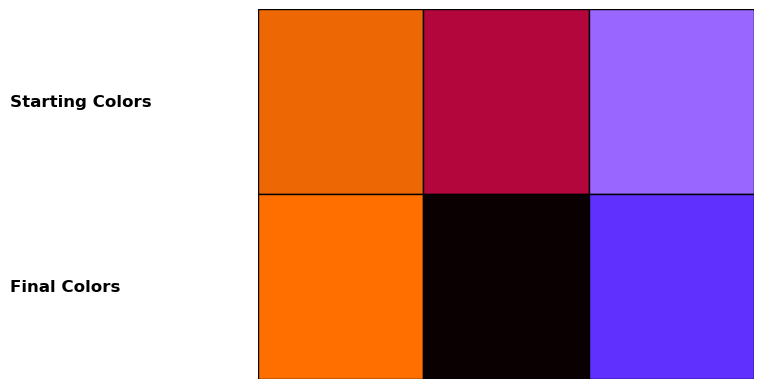

In [27]:
def draw_rgb_boxes_with_labels(top_row_colors, bottom_row_colors):
    """
    Draw two rows of RGB color boxes with labels, one row for each list of colors.

    Parameters:
        top_row_colors (list): A list of tuples representing RGB values for the top row.
        bottom_row_colors (list): A list of tuples representing RGB values for the bottom row.

    Example:
        >>> draw_rgb_boxes_with_labels([(255, 0, 0), (0, 255, 0)], [(0, 0, 255), (255, 255, 0)])
    """
    
    fig, ax = plt.subplots()
    num_boxes = max(len(top_row_colors), len(bottom_row_colors))
    ax.set_xlim([0, num_boxes])
    ax.set_ylim([0, 2])
    ax.axis('off')  # Turn off the axis

    # Function to add rectangles and labels to the plot
    def add_rectangles_and_labels(colors, row, label):
        for col, color in enumerate(colors):
            # Normalize RGB values
            norm_color = tuple([c / 255 for c in color])

            # Create a rectangle patch
            rect = patches.Rectangle((col, row), 1, 1, linewidth=1, edgecolor='black', facecolor=norm_color)
            ax.add_patch(rect)

        # Add label
        plt.text(-1.5, row + 0.5, label, ha='left', va='center', fontsize=12, weight='bold')

    # Add rectangles and labels for both rows
    add_rectangles_and_labels(top_row_colors, 1, "Starting Colors")
    add_rectangles_and_labels(bottom_row_colors, 0, "Final Colors")

    plt.show()

draw_rgb_boxes_with_labels(start_colors, colors)